<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-2-Sprint-4-Model-Validation/blob/master/pump_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can you predict which water pumps are faulty?
*A predictive model challenge from DrivenData a platform that organizes data science competitions around problems with humanitarian impact. *
* Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don’t work at all? 
* Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. 
* A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


[weeklong challenge just for our Lambda School DS1 cohort.](https://www.kaggle.com/c/ds1-predictive-modeling-challenge)

### Download Kaggle Dataset into Google Drive, so that CoLab can assess these data.

In [3]:
!pip install kaggle

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/


In [6]:
!kaggle  competitions download -c ds1-predictive-modeling-challenge

  0% 0.00/236k [00:00<?, ?B/s]
100% 236k/236k [00:00<00:00, 70.6MB/s]
  0% 0.00/948k [00:00<?, ?B/s]
100% 948k/948k [00:00<00:00, 61.1MB/s]
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 64.6MB/s]
  0% 0.00/3.81M [00:00<?, ?B/s]
100% 3.81M/3.81M [00:00<00:00, 125MB/s]


In [7]:
!unzip train_features.csv.zip
!unzip train_labels.csv.zip
!unzip test_features.csv.zip


Archive:  train_features.csv.zip
  inflating: train_features.csv      
Archive:  train_labels.csv.zip
  inflating: train_labels.csv        
Archive:  test_features.csv.zip
  inflating: test_features.csv       


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [105]:
df_train = pd.read_csv('train_features.csv',index_col='id')
df_test = pd.read_csv('test_features.csv',index_col='id')
df_label = pd.read_csv('train_labels.csv')
df_sample = pd.read_csv('sample_submission.csv')

df_train.shape, df_test.shape, df_label.shape, df_sample.shape

((59400, 39), (14358, 39), (59400, 2), (14358, 2))

## Begin project by establishing Baseline metrics.
### Method 1: Majority baseline by value_counts. Random chance predictions have 
1. 54% functional well pump.
2. 38% non-functional pump.
3. 7%  repairable.

In [55]:
df_label.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [0]:
accuracy = df_label.status_group.value_counts(normalize=True)[0]

# Create score dataframe
score=pd.DataFrame(columns=['method','accuracy', 'shape'])
score.loc[0]=['majority_baseline',accuracy, (1,1)]

### Method 2: Feed LogisticRegression with numeric only.
* Numeric data value can range so wide that no regression iteration can ever be enough to converge. 
* Do not increase max_iteration of LogisticRegression, instead call a Scaler.

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

df_num = df_train.select_dtypes(np.number)

X=df_num
y = df_label.status_group

pipe = make_pipeline(
    RobustScaler(),
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=500)
    )

pipe.fit(X,y)

y_pred = pipe.predict(X)

accuracy= accuracy_score(y, y_pred)
score.loc[score.shape[0]]=['logReg_num', accuracy, X.shape]

print('Accuracy score=', accuracy)

Accuracy score= 0.5577946127946128


### Method 2: LogisticRegression with non-numeric categorical value object only.
* Encoders are friend of LogisticRegression, transforming non-numeric data  into numeric.
#### But nasty data character are hidden landmine bomb to Encoder. 
* Nasty datatype - NaN, '?', space in front/after, keyword:False, True, None .



In [0]:
def obj_cleanup(X5):
  X5.replace('\ 2\ ','two', regex=True, inplace=True)
  X5.replace(';','semicolon', regex=True, inplace=True)
  X5.replace("`", "back_quote", regex=True, inplace=True)
  X5.replace("'", "quote", regex=True, inplace=True)
  X5.replace("\(", "left_paren", regex=True, inplace=True)
  X5.replace("\)", "right_paren", regex=True, inplace=True)
  X5.replace("\/", "back_slash", regex=True, inplace=True)
  X5.replace("\\", "fwd_slash", regex=True, inplace=True)
  X5.replace("   ", "space", regex=True, inplace=True)
  X5.replace("\.", "dot", regex=True, inplace=True)
  return X5

In [0]:
# Example of finding problem maker
'''test = df.select_dtypes([np.object]).apply(lambda x: x.str.contains(';').any())
str_cols = df.select_dtypes([np.object]).columns
str_cols[test]'''

#df_test.loc[df_test['scheme_name'].str.contains('\.')]['scheme_name']

In [0]:
# Best define a function for data cleanup, so that the cleanup process can be
# applied to df_test data as well.

def cleanup(data):
  data.fillna('unknown', axis=1, inplace=True)
  
  # Nasty keyword(False, True) object breaks OneHotEncoder
  data['permit'] = data['permit'].astype(dtype='str')
  data['public_meeting'] = data['public_meeting'].astype(dtype='str')
  
  # One unique value adds no value, hence removed
  data.drop('recorded_by', axis=1, inplace=True)
  
  return data

In [9]:
# Example of nasty keyword data value hidden in permit column out 39 column features.
df_train.permit.unique()

array([False, True, nan], dtype=object)

In [59]:
# copy()- make sure all cleanup work are copied over.
df_train = cleanup(df_train).copy()
df_test = cleanup(df_test).copy()

df_train.permit.unique()

array(['False', 'True', 'unknown'], dtype=object)

In [13]:
# Any NaN will show as True
df_train.isnull().any().any()

False

#### High cardinality features add no value but noise to regression.  
* Filter out features with high number of unique categorical values by eyeballing method.
* nunique() function lists out number of unique categorical values.


In [0]:
# Exclude non-number columns with high number of categorical values. 
# High cardinality columns when split by encoding turns into many useless noisy data.
filter_cols  = df_train.select_dtypes(object).nunique().sort_values().index.tolist()[:-6]
df_obj = df_train[filter_cols].copy()

#### OneHotEncoding non-numeric categorical value into 0 and 1.
* Automatically increase both training accuracy score and testing bias into the model.

In [61]:
from sklearn.preprocessing import OneHotEncoder

X=df_obj
y=df_label.status_group

pipe = make_pipeline(
    OneHotEncoder(categories='auto'),
    LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=500))

pipe.fit(X,y)
y_pred = pipe.predict(X)
accuracy=accuracy_score(y, y_pred)

score.loc[score.shape[0]] = ['logReg_OneHotEncoder', accuracy, X.shape]
print('Accuracy score=', accuracy)

Accuracy score= 0.757020202020202


### Method 3: LogisticRegression with categorical value without Encoder.
* Transforming unique categorical value into nominal value is more accurate and efficient than OneHotEncoding.

In [62]:
df_cat = df_obj.apply(lambda x: x.astype('category').cat.codes)

X=df_cat
y=df_label.status_group

pipe = make_pipeline(
    RobustScaler(),
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=500)
    )

pipe.fit(X,y)

y_pred = pipe.predict(X)

accuracy=accuracy_score(y, y_pred)
score.loc[score.shape[0]] = ['logReg_cat_codes', accuracy, X.shape]
print('Accuracy score=', accuracy)

Accuracy score= 0.6286531986531987


### Method 4: Include all non-numeric categorical value (all cardinality) using cat code.
* Converting non-numeric to category code, solve the high cardinality columns problem.

In [63]:
df_cat_all = df_train.apply(lambda x: x.astype('category').cat.codes)
X=df_cat_all
y=df_label.status_group

pipe = make_pipeline(
    RobustScaler(),
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=500)
    )

pipe.fit(X,y)

y_pred = pipe.predict(X)

accuracy=accuracy_score(y, y_pred)
score.loc[score.shape[0]] = ['logReg_cat_allcodes', accuracy, X.shape]
print('Accuracy score=', accuracy)

Accuracy score= 0.6557912457912458


### Method 5: Everything both numeric and non-numeric using Encoder
* OneHotEncoder going crazy transforming both numeric and non-numeric, turning LogisticRegression into a neural network overfitting model?
#### Accuracy of 96% on training data? OneHotEncoder not to be trusted. 
#### Using this model to predict on df_test data, yields nonsense category unknown error.

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

X=df_train
y=df_label.status_group

pipe = make_pipeline(
    OneHotEncoder(categories='auto'),
    LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=2000))

pipe.fit(X,y)
y_pred = pipe.predict(X)
accuracy=accuracy_score(y, y_pred)

score.loc[score.shape[0]] = ['logReg_allnumcat_Encoding', accuracy, X.shape]
print('Accuracy score=', accuracy)

Accuracy score= 0.9674579124579125


### Exploring different Classifier

#### DecisionTreeClassifier
* Fast and raise accuracy to reasonable 74%.

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

X=df_cat_all
y = df_label.status_group.values

clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            X, y,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = 1,
                            verbose = 1)

score.loc[score.shape[0]] = ['DecisionTreeClassifier_all', cv_score.max(), X.shape]
cv_score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s finished


array([0.74191919, 0.74358586, 0.73823232])

#### RandomForestClassifier


In [66]:
# Uncertain what to put in this dictionary, use this function call that 
# will give you a list of the parameters you can use:

from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [67]:
# Fitting RandomForestClassifier with all features both numerical and categorical
# cat code values.

from sklearn.model_selection import GridSearchCV

X = df_cat_all
y = df_label.status_group

param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [6, 10, 20, 30]
}
gridsearch = GridSearchCV(RandomForestClassifier(n_jobs = 1), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=1)
gridsearch.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30], 'max_depth': [6, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [70]:
# GridsearchCV best score

score.loc[score.shape[0]] = ['RandomForestClassifier_all', gridsearch.best_score_, X.shape]
gridsearch.best_score_

0.8078619528619528

In [68]:
# Best estimator recommendation
gridsearch.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Prepare validation testing for RandomForestClassifier and XgBoost.

In [0]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
  
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
                            df_cat_all, df_label)

In [88]:
# X_train and X_test from cross_val_split if setup

clf = RandomForestClassifier(max_depth = 20, 
                             n_estimators = 30, 
                             n_jobs = 1)
clf.fit(X_train, y_train.status_group)
clf.score(X_test, y_test.status_group)

0.8069023569023569

### XgBoost

In [89]:
y_train.columns

Index(['id', 'status_group'], dtype='object')

In [0]:
y = y_train.apply(lambda x: x.astype('category').cat.codes)
#label_num=df_label.apply(lambda x: x.astype('category').cat.codes)

In [102]:
import xgboost as xgb

y_num = y_train.apply(lambda x: x.astype('category').cat.codes)
y_test_num = y_test.apply(lambda x: x.astype('category').cat.codes)

xg_train = xgb.DMatrix(X_train, label=y_num.status_group)
xg_test = xgb.DMatrix(X_test, label=y_test_num.status_group)
xg_train.save_binary('train.buffer')
xg_test.save_binary('train.buffer')
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
param['silent'] = 1 # cleans up the output
param['num_class'] = 3 # number of classes in target label

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 30
bst = xgb.train(param, xg_train, num_round, watchlist)

# get prediction
y_pred1 = bst.predict(xg_train)
y_pred2 = bst.predict(xg_test)
print('Train accuracy score:',accuracy_score(y_num.status_group,y_pred1))
print('Test accuracy score:',accuracy_score(y_test_num.status_group,y_pred2))

score.loc[score.shape[0]] = ['XgBoost_all', accuracy_score(y_num.status_group,y_pred1), X_train.shape]

[0]	train-merror:0.273443	test-merror:0.287037
[1]	train-merror:0.266035	test-merror:0.278114
[2]	train-merror:0.261995	test-merror:0.270539
[3]	train-merror:0.258228	test-merror:0.267003
[4]	train-merror:0.256145	test-merror:0.267003
[5]	train-merror:0.253956	test-merror:0.263973
[6]	train-merror:0.251178	test-merror:0.26229
[7]	train-merror:0.247496	test-merror:0.257912
[8]	train-merror:0.243897	test-merror:0.254377
[9]	train-merror:0.240088	test-merror:0.25303
[10]	train-merror:0.2383	test-merror:0.252357
[11]	train-merror:0.232513	test-merror:0.248485
[12]	train-merror:0.229503	test-merror:0.245118
[13]	train-merror:0.228262	test-merror:0.243771
[14]	train-merror:0.225231	test-merror:0.240572
[15]	train-merror:0.222496	test-merror:0.238721
[16]	train-merror:0.222138	test-merror:0.23771
[17]	train-merror:0.219234	test-merror:0.236364
[18]	train-merror:0.216288	test-merror:0.234175
[19]	train-merror:0.212563	test-merror:0.232323
[20]	train-merror:0.210753	test-merror:0.23064
[21]	tra

In [103]:
score

,method,accuracy,shape
0,majority_baseline,0.543081,"(1, 1)"
1,logReg_num,0.557795,"(59400, 9)"
2,logReg_OneHotEncoder,0.757020,"(59400, 23)"
3,logReg_cat_codes,0.628653,"(59400, 23)"
4,logReg_cat_allcodes,0.655791,"(59400, 38)"
5,logReg_allnumcat_Encoding,0.967458,"(59400, 38)"
6,DecisionTreeClassifier_all,0.743586,"(59400, 38)"
7,RandomForestClassifier_all,0.807862,"(59400, 38)"
8,XgBoost_all,0.802441,"(47520, 38)"


## Data Exploration - making sense of data

In [0]:
# Converting string label into numerical label

label_num=df_label.apply(lambda x: x.astype('category').cat.codes)

In [0]:
# combine training data and label for analysis convenience

data = pd.concat([df_train, label_num], axis=1)

### Numerical data are great for visual data exploration, but not so good for classification data modeling.
* Numerical data generally needs to group in meaningful ways in order for classifier to find pattern.
* Individually each continuous numerical data represents noise to claissfier.
* Quality of numerical data may be impacted by too many missing data.
#### df_train.describe() return-Count:id=57948 rows, while columns=57588. Missing data=360. 
#### df_train.isna().sum() return-11908 missing?

#### Water_quality impact on well pump functionalities? Can't tell.

In [58]:
df_pivot= data[['water_quality','status_group','basin']]
df_pivot.pivot_table(index='water_quality',
                           columns='status_group', aggfunc='count')


basin             
status_group          0.0   1.0    2.0
water_quality                         
coloured              207    26    159
fluoride               90    11     54
fluoride abandoned     10     1      3
milky                 346    54    249
salty                2098   278   1491
salty abandoned       133    25     98
soft                22235  2917  15530
unknown               793   120    564

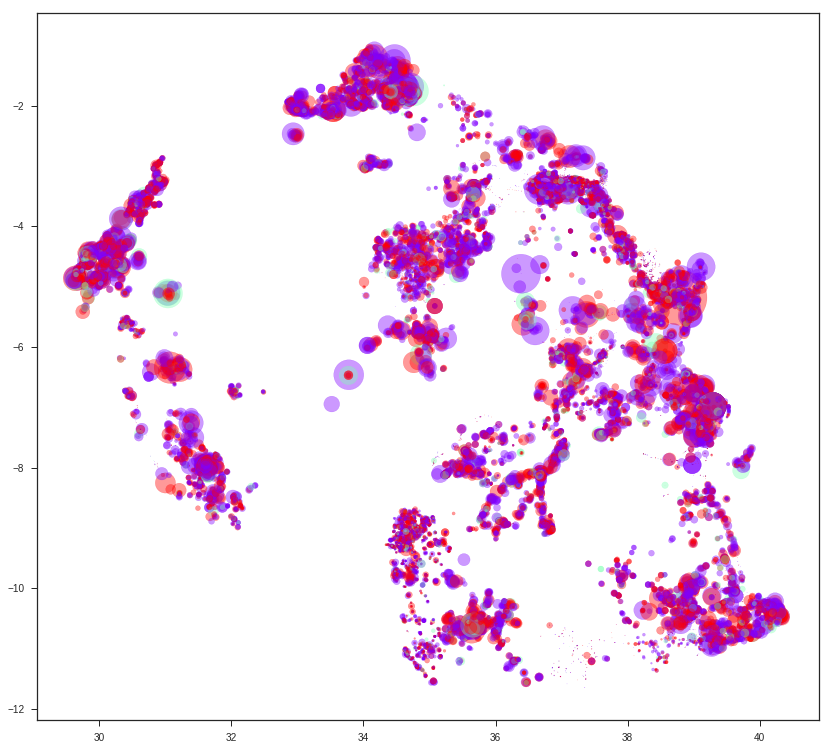

In [62]:
# remove the row observation where longitude = 0
data = data.drop(data[data.longitude == 0].index)

plt.figure(figsize=(14,13))
plt.scatter(data.longitude, data.latitude, alpha=0.4,
            s=data.population/10,   
            label=data.status_group,
            c=data.status_group, cmap='rainbow',
           )
#plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='black')

###  Seaborn correlation table plot shows relationship between numerical features and status_group.
* Weak direct correlation between numerical features and target label, status_group.
* Some correlation between district and region codes, gps_height and construction_year.

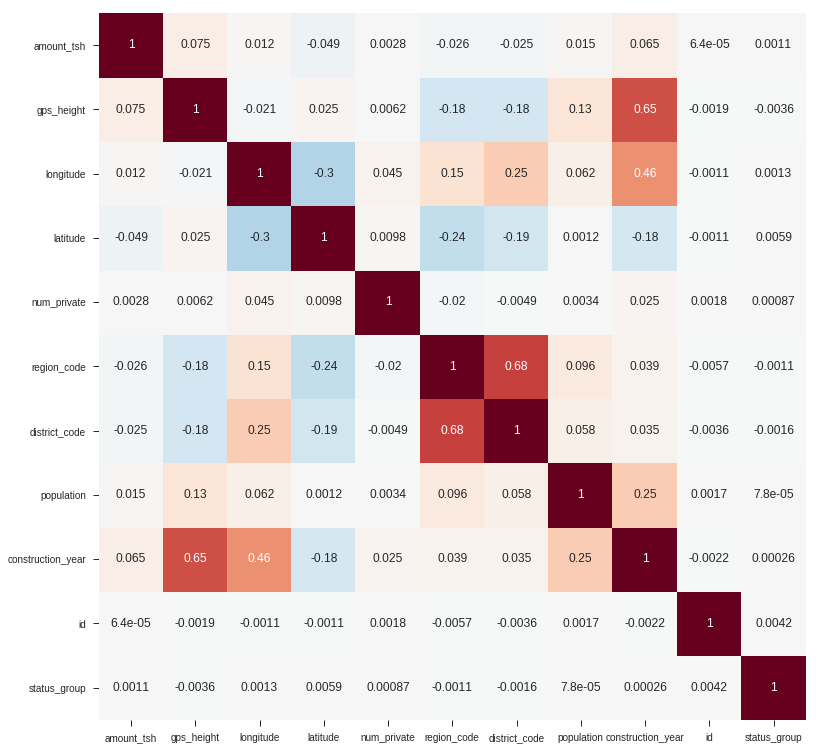

In [63]:
corr_table = data.corr()
plt.figure(figsize=(14,13))
sns.heatmap(corr_table, square=True, annot=True, cbar=False);

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


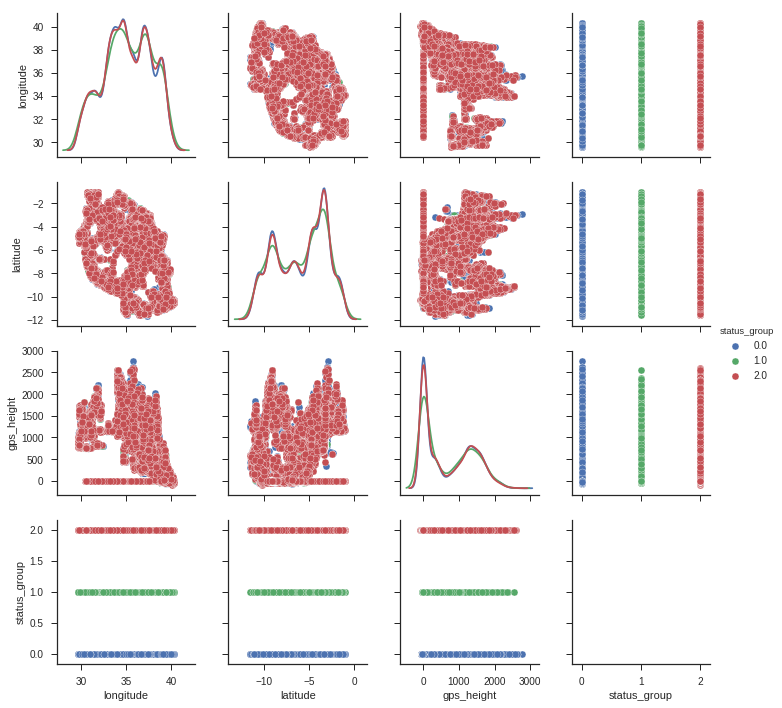

In [64]:
import seaborn as sns
sns.set(style='ticks')
sns.pairplot(data[['longitude', 'latitude', 'gps_height', 'status_group']],\
            hue='status_group', diag_kind='kde');

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Water Pump Construction by Years')

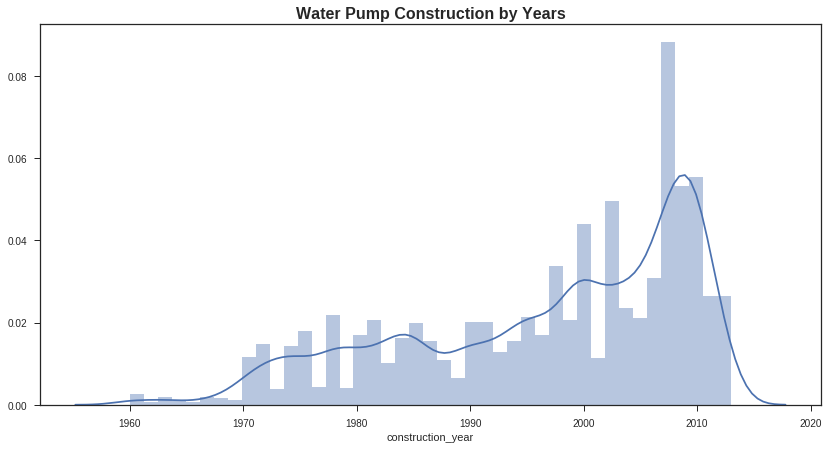

In [45]:
plt.figure(figsize=(14, 7))
sns.distplot(data['construction_year'][data['construction_year']>0]);
plt.title("Water Pump Construction by Years", fontsize=16, fontweight='bold')

### Numerical data feature engineering idea. But have no impact on prediction of pump functionality.  

In [0]:
# feature engineering-turning continuous numeric into discrete value.
# Hopefully logistic classifier can map discrete value to target
def num_cleanup(X1):
  '''
  date_recorded
  ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year']
  '''
  
  # categorical value nan converted to unknown to be processed by regression.
  X2 = X1.fillna('unknown')
  
  # added recorded_year_built
  # convert date_recorded as year 
  dates = pd.to_datetime(X2.date_recorded)
  X2['recorded_year_built'] = dates.dt.year - X2['construction_year']
  X2.loc[X2.recorded_year_built > 1000 ] = 0
  X2.date_recorded = dates.dt.year
  
  #
  bins=[-100,0,100,500,1000,1250,1500,2000]
  labels=[0,100,500,1000,1250,1500,2000]
  #X2['gps_height_bin']= pd.cut(X2.gps_height, bins, labels=labels)
  #X2.drop(['gps_height'], axis=1, inplace=True)
  
  # replace longitude, latitude with centroid
  X2['centroid']=add_local_gps(X1)
  #X2.drop(['longitude','latitude'], axis=1, inplace=True)
  
  type_dict = {'amount_tsh':'float64',    # nunique()=98
               'date_recorded':'float64', # date into year
               'gps_height':'float64',
               #'gps_height_bin':'float64',    #added bins; reduce score 0.02
               'centroid':'float64',  # centroid=25,2000: no impact on score.
               'num_private':'float64',   # nunique()=65
               'population':'float64',    # nunique()=1049
               'construction_year':'float64',   # nunique()=55
               'recorded_year_built':'float64', #added
               'region_code':'float64',   # nunique()=27
               'district_code':'float64'  # nunique=20 
              }
  X2 = X2.astype(dtype = type_dict)
  
  X2 = X2.fillna(0)

  return X2

#### DecisionTreeClassifier

In [0]:
# Xgboost

from xgboost import XGBClassifier
modelxgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 14, colsample_bytree = .4)

In [0]:
# Xgboost
from sklearn.model_selection import cross_val_score

score = (cross_val_score(modelxgb, X, y, cv=5,n_jobs = -1))
score.mean()

### Kaggle submission

In [0]:
#submission as format as df_sample
y_submission = pd.DataFrame()

y_submission['id'] = df_test.index
y_submission['status_group']=y_pred
y_submission.shape

In [0]:
from google.colab import files

y_submission.to_csv('data_all.csv', index=False)
files.download("data_all.csv")